In [1]:
# load the realted package
import numpy as np
import pandas as pd

# load the preprocessing package(mainly sklearn)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import r2_score

# load ploting packages
import matplotlib.pyplot as plt
import seaborn as sns


# load XGBoost, A boosting method.
import xgboost as xgb
from xgboost import plot_tree

import shap

In [2]:
features_name = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11','d12', 'd13', 'd14', 'd15', 'd16']

wt_d1_16_distances = np.load("/users/chaoy/scratch/0.proj_kpc/2.data_anal/2.disanal/3.new_features_16_distances/kpc_wt_d1_16_features.npy")
wt_d2_16_distances = np.load("/users/chaoy/scratch/0.proj_kpc/2.data_anal/2.disanal/3.new_features_16_distances/kpc_wt_d2_16_features.npy")
y72_d1_16_distances = np.load("/users/chaoy/scratch/0.proj_kpc/2.data_anal/2.disanal/3.new_features_16_distances/kpc_y72_d1_16_features.npy")
y72_d2_16_distances = np.load("/users/chaoy/scratch/0.proj_kpc/2.data_anal/2.disanal/3.new_features_16_distances/kpc_y72_d2_16_features.npy")

# concatenate four systems together
features = np.concatenate((wt_d1_16_distances, wt_d2_16_distances, y72_d1_16_distances, y72_d2_16_distances), axis = 1).T

# build a dataframe for features
features_df = pd.DataFrame(features, columns = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11','d12', 'd13', 'd14', 'd15', 'd16'])


# load energy
system_lables = ["wt_d1"] * 200 + ["wt_d2"] * 200 + ["y72_d1"] * 200 + ["y72_d2"] * 200

# load the barrier energy for every pathway
wt_d1_bar_ene = np.load("/users/chaoy/scratch/0.proj_kpc/1.sample/1.kpc_wt_d1/7.sp/0.b3lyp_d3/charge_ene/enes_all_paths.npz")['ene_barrier']
wt_d2_bar_ene = np.load("/users/chaoy/scratch/0.proj_kpc/1.sample/0.kpc_wt_d2/7.sp/0.b3lyp_d3/charge_ene/enes_all_paths.npz")['ene_barrier']
y72_d1_bar_ene = np.load("/users/chaoy/scratch/0.proj_kpc/1.sample/3.kpc_y72_d1/7.sp/0.b3lyp_d3/charge_ene/enes_all_paths.npz")['ene_barrier']
y72_d2_bar_ene = np.load("/users/chaoy/scratch/0.proj_kpc/1.sample/2.kpc_y72_d2/7.sp/0.b3lyp_d3/charge_ene/enes_all_paths.npz")['ene_barrier']

# merge barrier energy together
bar_ene = np.concatenate((wt_d1_bar_ene, wt_d2_bar_ene, y72_d1_bar_ene, y72_d2_bar_ene))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features_df, bar_ene, test_size= 0.1, random_state=42, stratify = system_lables)
dtrain = xgb.DMatrix(X_train, label =y_train, feature_names = features_name)
dtest = xgb.DMatrix(X_test, label =y_test, feature_names = features_name)
evallist  = [(dtest,'eval'), (dtrain,'train')]
num_boost_round = 300

In [7]:
def model_train(para,dtrain,num_boost_round, evallist):
    xgb_m = xgb.train(para, 
                  dtrain, 
                  num_boost_round = num_boost_round, 
                  evals = evallist,
                  early_stopping_rounds=20,     
                      verbose_eval = False,
             )
    return xgb_m

In [10]:
para_best_model = {'verbosity':1,
        'max_depth':3,
        'subsample':0.6,
        'objective':'reg:squarederror',
        'eval_metric':'mae',
        'eta':0.1,
        'gamma': 1,
        'min_child_weight':1,
           }
xgb_new = model_train(para_best_model, dtrain, 300 , evallist)
preds = xgb_new.predict(dtest)
mae = np.mean(abs(preds-y_test))

# SHAP value

In [11]:
explainer = shap.Explainer(xgb_new)
shap_value = explainer((features_df))

# KPC-WT/IPM-$\Delta $1

Text(0.55, 0.92, 'SHAP values for KPC-WT/IPM-$\\Delta $1')

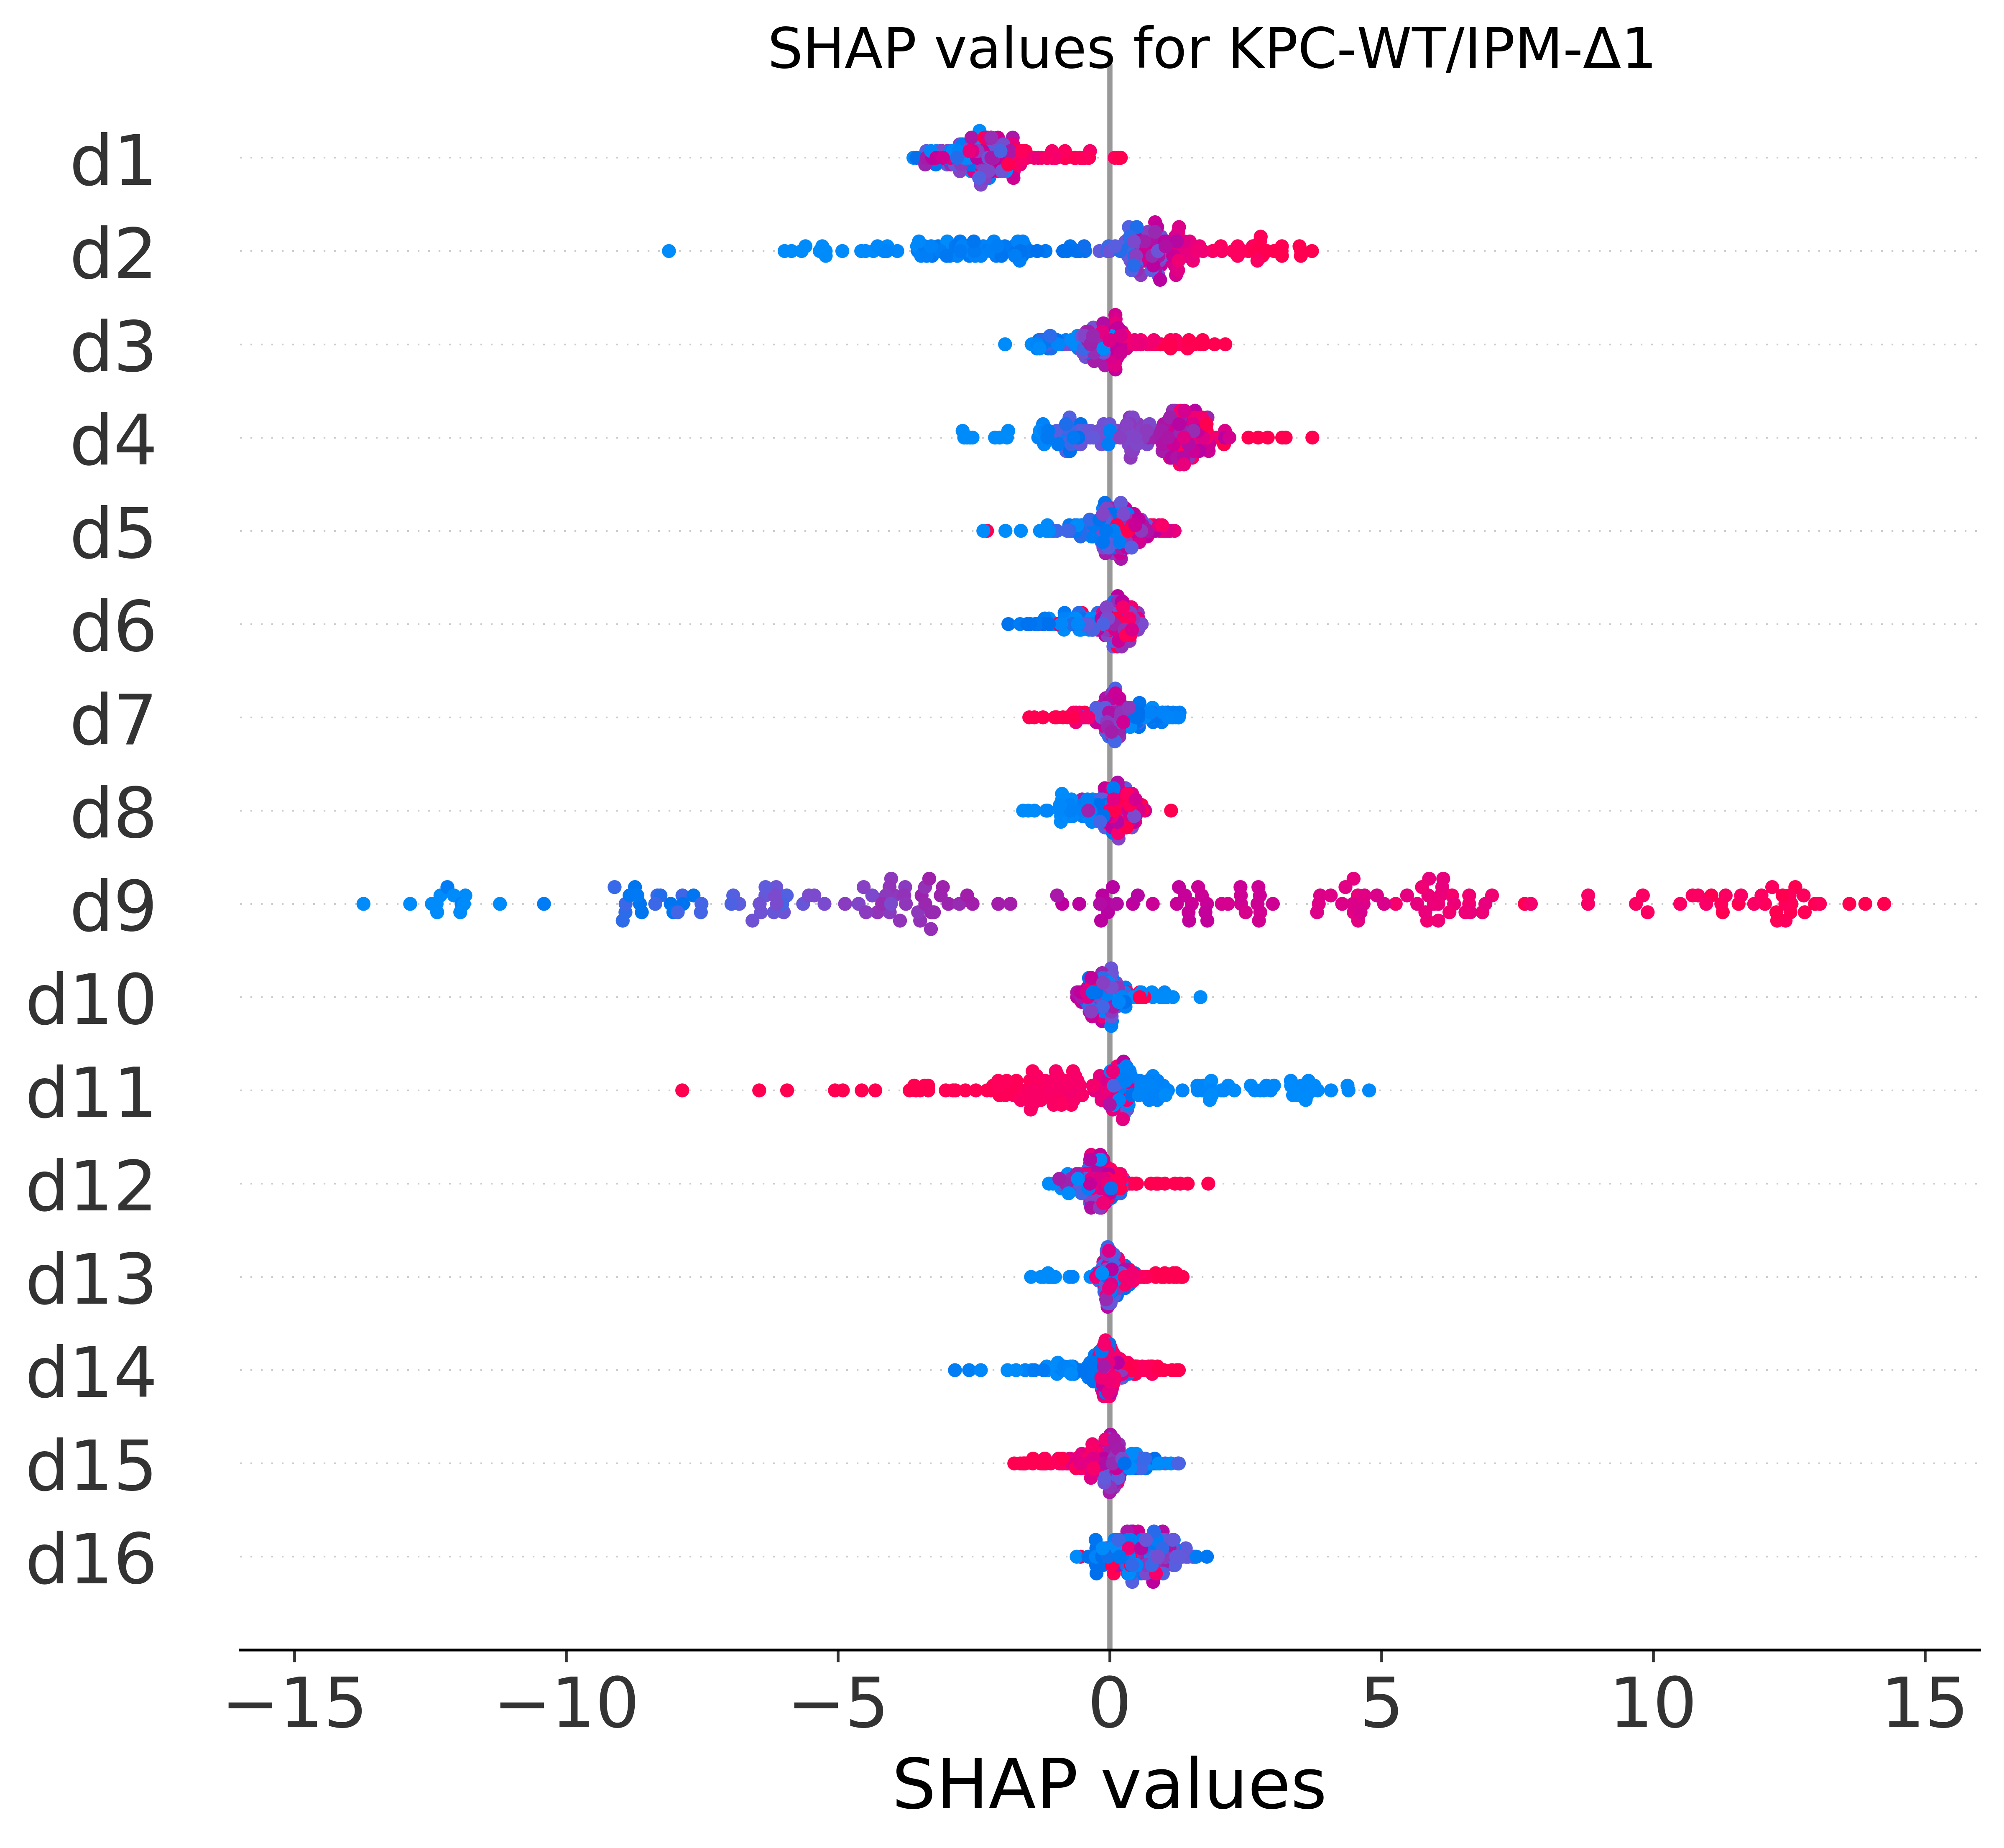

In [26]:
order = [
    "d1",
    "d2",
    "d3",
    "d4",
    "d5",
    "d6",
    "d7",
    "d8",
    "d9",
    "d10",
    "d11",
    "d12",
    "d13",
    "d14",
    "d15",
    "d16",
]

col2num = {col: i for i, col in enumerate(features_df.columns)}

order = list(map(col2num.get, order))

csfont = {'fontname':'Times New Roman'}

fig, ax,  = plt.subplots(figsize=(3.75, 2.5)  ,dpi=600, facecolor='w', edgecolor='k', )
plt.subplots_adjust(left=0.25/3.75, right=3.5/3.75, top=2.25/2.5, bottom=.25/2.5)
shap.plots.beeswarm(shap_value[0:200], order = order, max_display=20, show=False, color_bar = False, )  #order = shap_value.abs.mean(0),
ax.set_yticks(np.arange(0, len(features_name)))

ax.set_xlabel('SHAP values', fontsize = 20)
ax.set_xlim(-16,16)

ax.tick_params(axis='both', which='major', labelsize=20)
fig.suptitle(r'SHAP values for KPC-WT/IPM-$\Delta $1', fontsize = 16,x = 0.55,y=0.92)

#, ha='left', va='top', rotation=-40, rotation_mode="anchor")
# plt.savefig("./16_feature_stratify/kpc_wt_d1.png",dpi=600, bbox_inches='tight')

# KPC-WT/IPM-$\Delta $2

Text(0.55, 0.92, 'SHAP values for KPC-WT/IPM-$\\Delta $2')

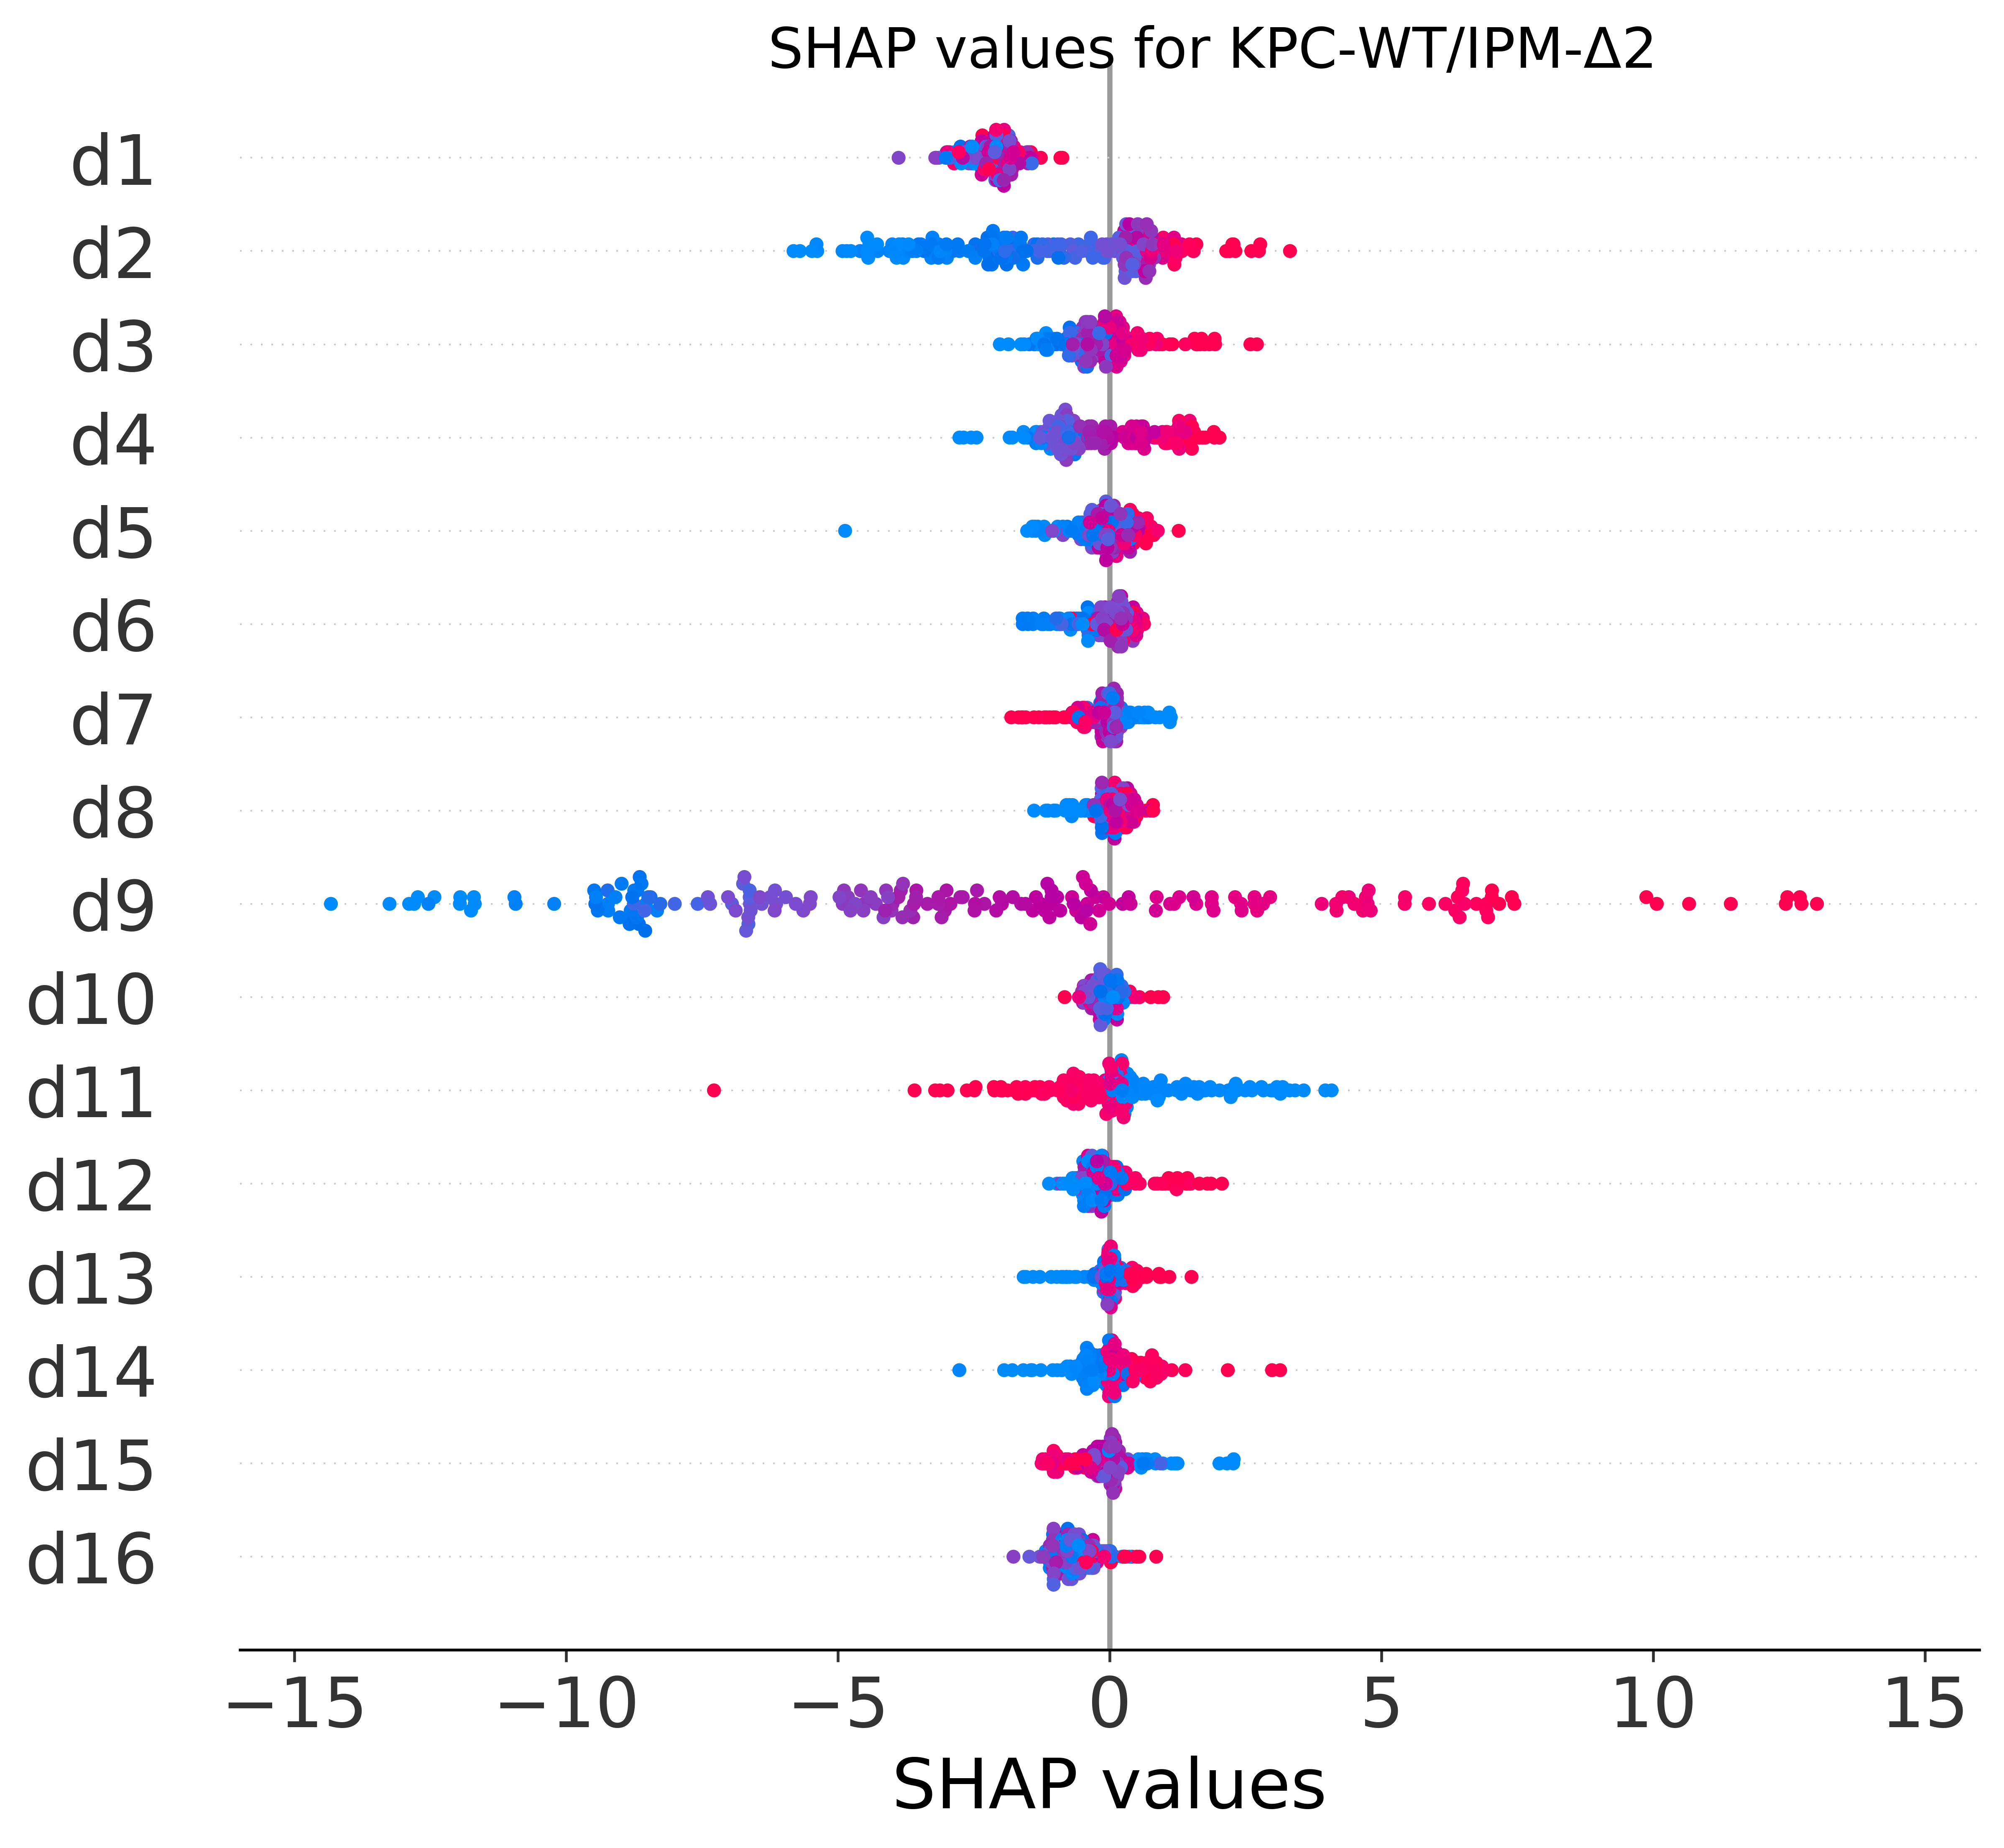

In [30]:
order = [
    "d1",
    "d2",
    "d3",
    "d4",
    "d5",
    "d6",
    "d7",
    "d8",
    "d9",
    "d10",
    "d11",
    "d12",
    "d13",
    "d14",
    "d15",
    "d16",
]

col2num = {col: i for i, col in enumerate(features_df.columns)}

order = list(map(col2num.get, order))

csfont = {'fontname':'Times New Roman'}

fig, ax,  = plt.subplots(figsize=(3.75, 2.5)  ,dpi=600, facecolor='w', edgecolor='k', )
plt.subplots_adjust(left=0.25/3.75, right=3.5/3.75, top=2.25/2.5, bottom=.25/2.5)
shap.plots.beeswarm(shap_value[200:400], order = order, max_display=20, show=False, color_bar = False, )  #order = shap_value.abs.mean(0),
ax.set_yticks(np.arange(0, len(features_name)))

ax.set_xlabel('SHAP values', fontsize = 20)
ax.set_xlim(-16,16)

ax.tick_params(axis='both', which='major', labelsize=20)
fig.suptitle(r'SHAP values for KPC-WT/IPM-$\Delta $2', fontsize = 16,x = 0.55,y=0.92)

# KPC-F72Y/IPM-$\Delta$1

Text(0.55, 0.92, 'SHAP values for KPC-F72Y/IPM-$\\Delta $1')

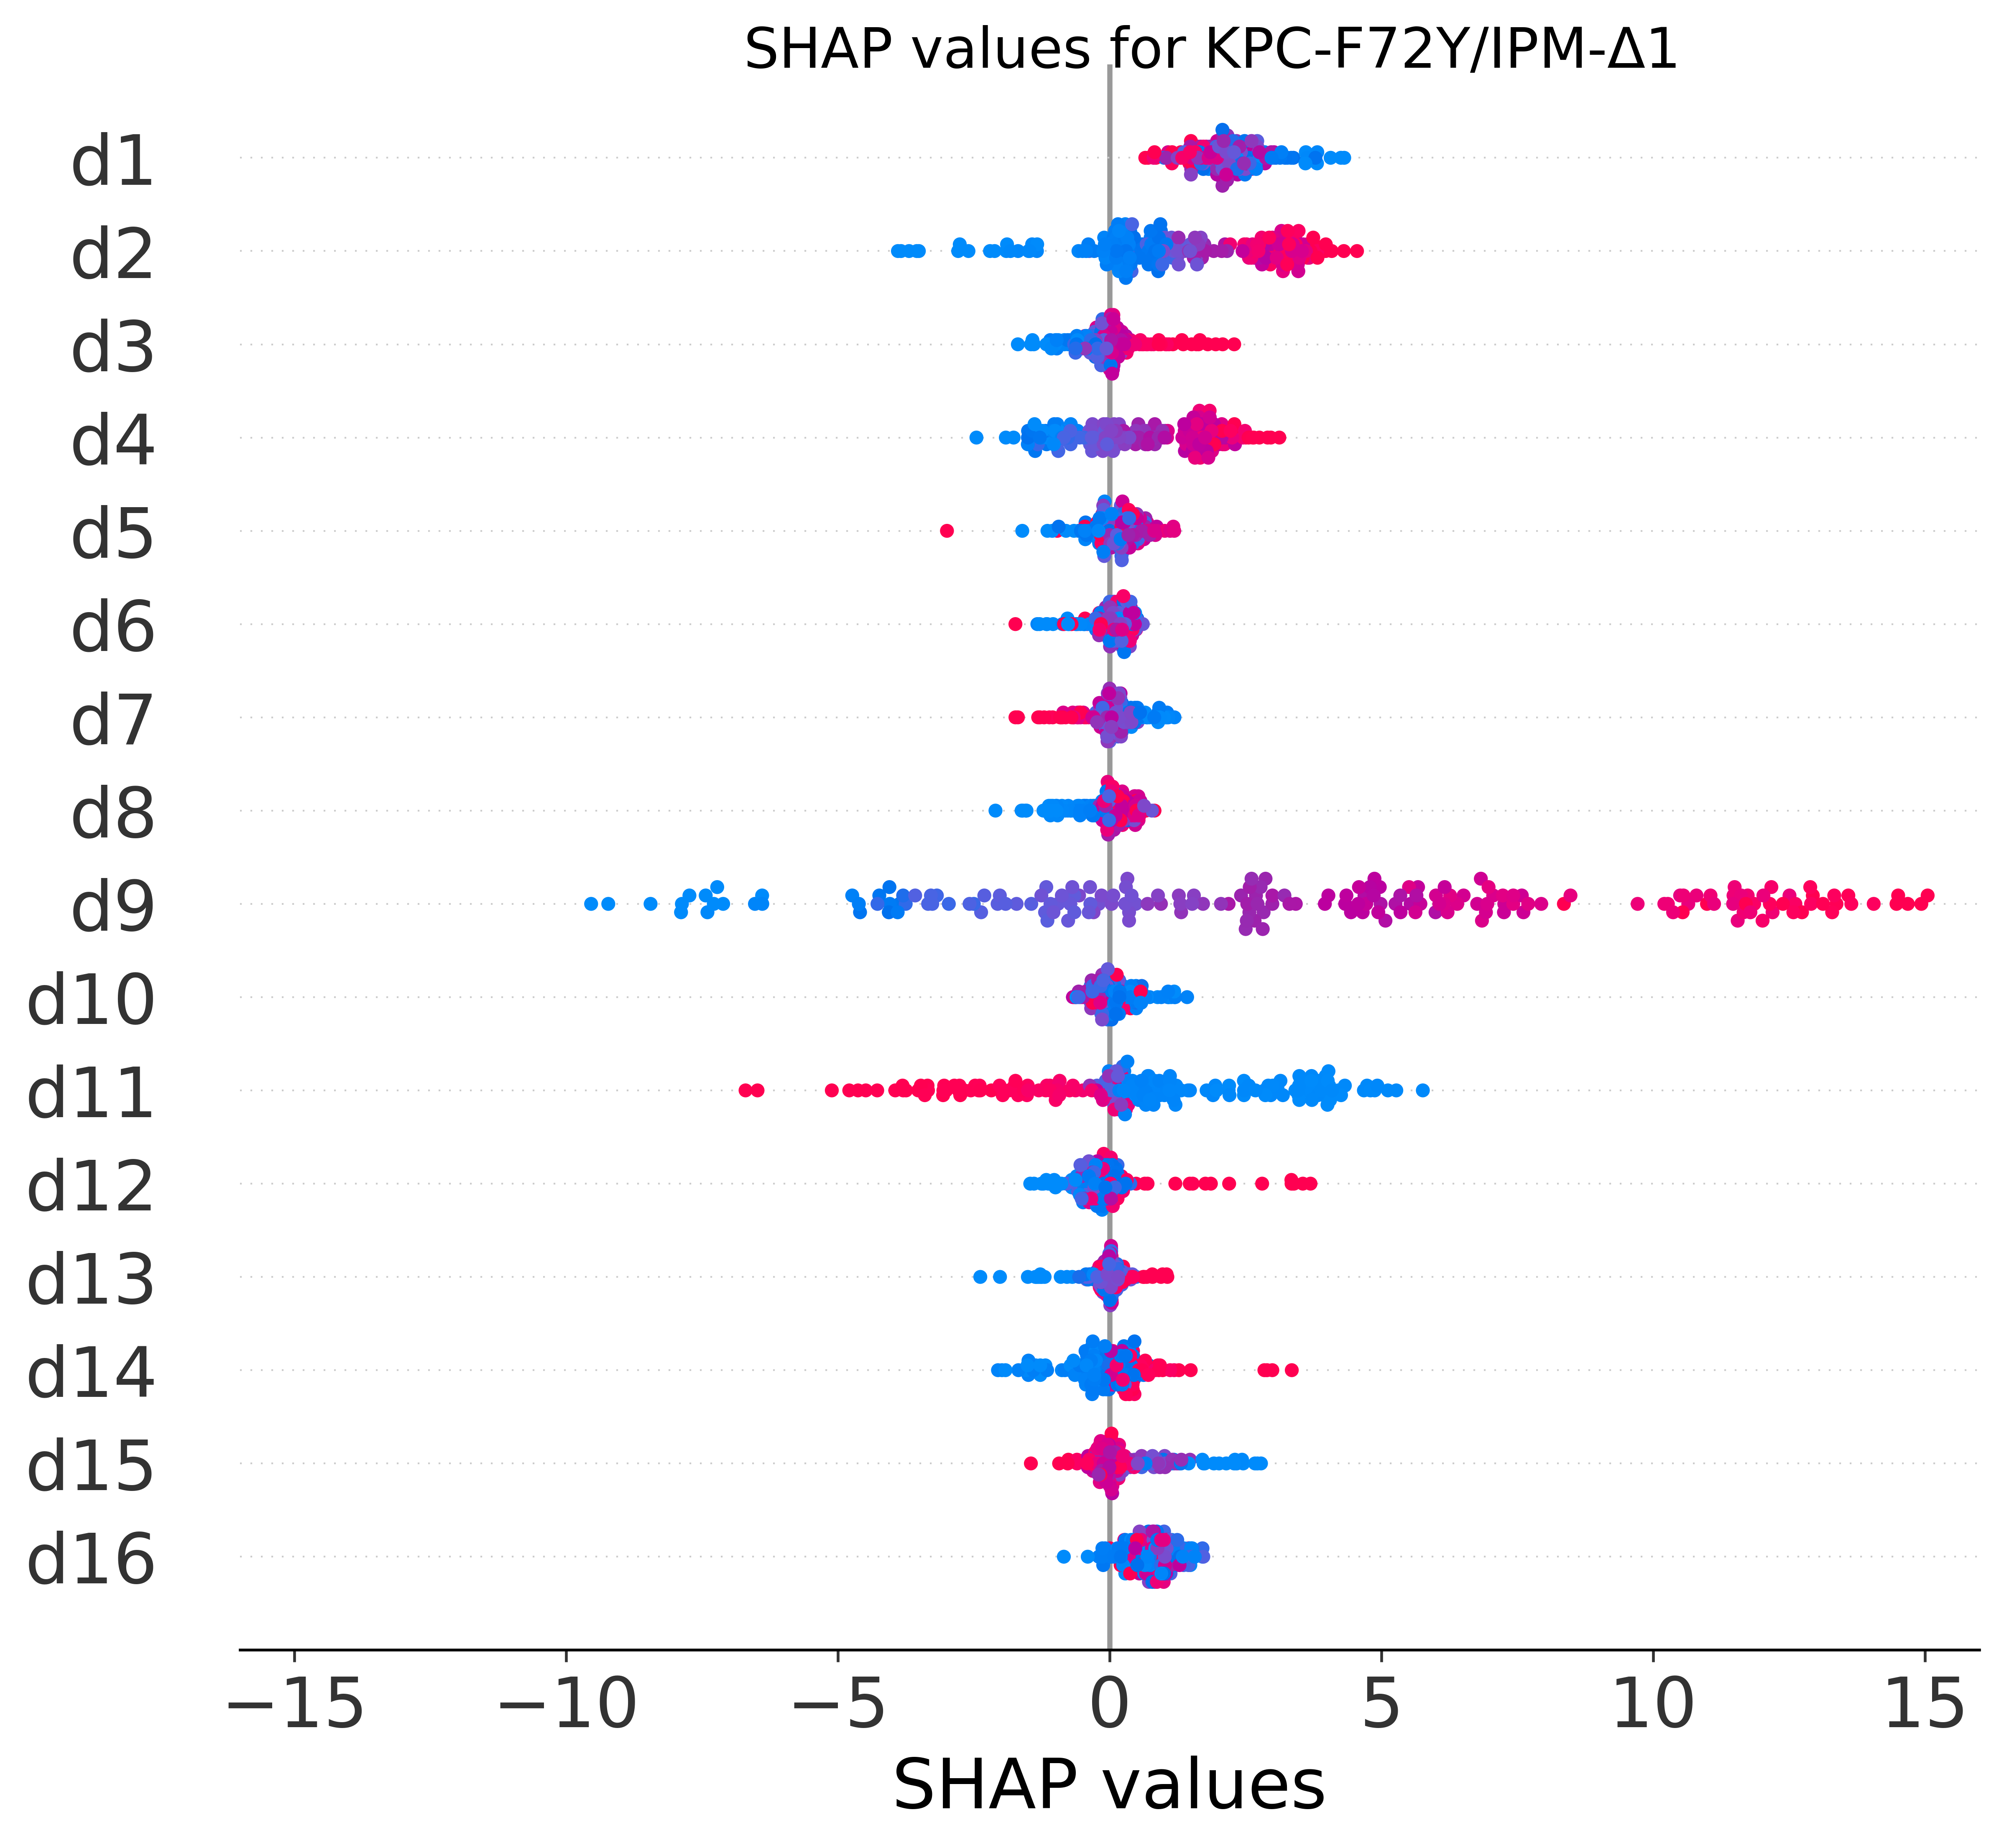

In [34]:
order = [
    "d1",
    "d2",
    "d3",
    "d4",
    "d5",
    "d6",
    "d7",
    "d8",
    "d9",
    "d10",
    "d11",
    "d12",
    "d13",
    "d14",
    "d15",
    "d16",
]

col2num = {col: i for i, col in enumerate(features_df.columns)}

order = list(map(col2num.get, order))

csfont = {'fontname':'Times New Roman'}

fig, ax,  = plt.subplots(figsize=(3.75, 2.5)  ,dpi=600, facecolor='w', edgecolor='k', )
plt.subplots_adjust(left=0.25/3.75, right=3.5/3.75, top=2.25/2.5, bottom=.25/2.5)
shap.plots.beeswarm(shap_value[400:600], order = order, max_display=20, show=False, color_bar = False, )  #order = shap_value.abs.mean(0),
ax.set_yticks(np.arange(0, len(features_name)))

ax.set_xlabel('SHAP values', fontsize = 20)
ax.set_xlim(-16,16)

ax.tick_params(axis='both', which='major', labelsize=20)
fig.suptitle(r'SHAP values for KPC-F72Y/IPM-$\Delta $1', fontsize = 16,x = 0.55,y=0.92)

# KPC-F72Y/IPM-$\Delta$2

Text(0.55, 0.92, 'SHAP values for KPC-F72Y/IPM-$\\Delta $2')

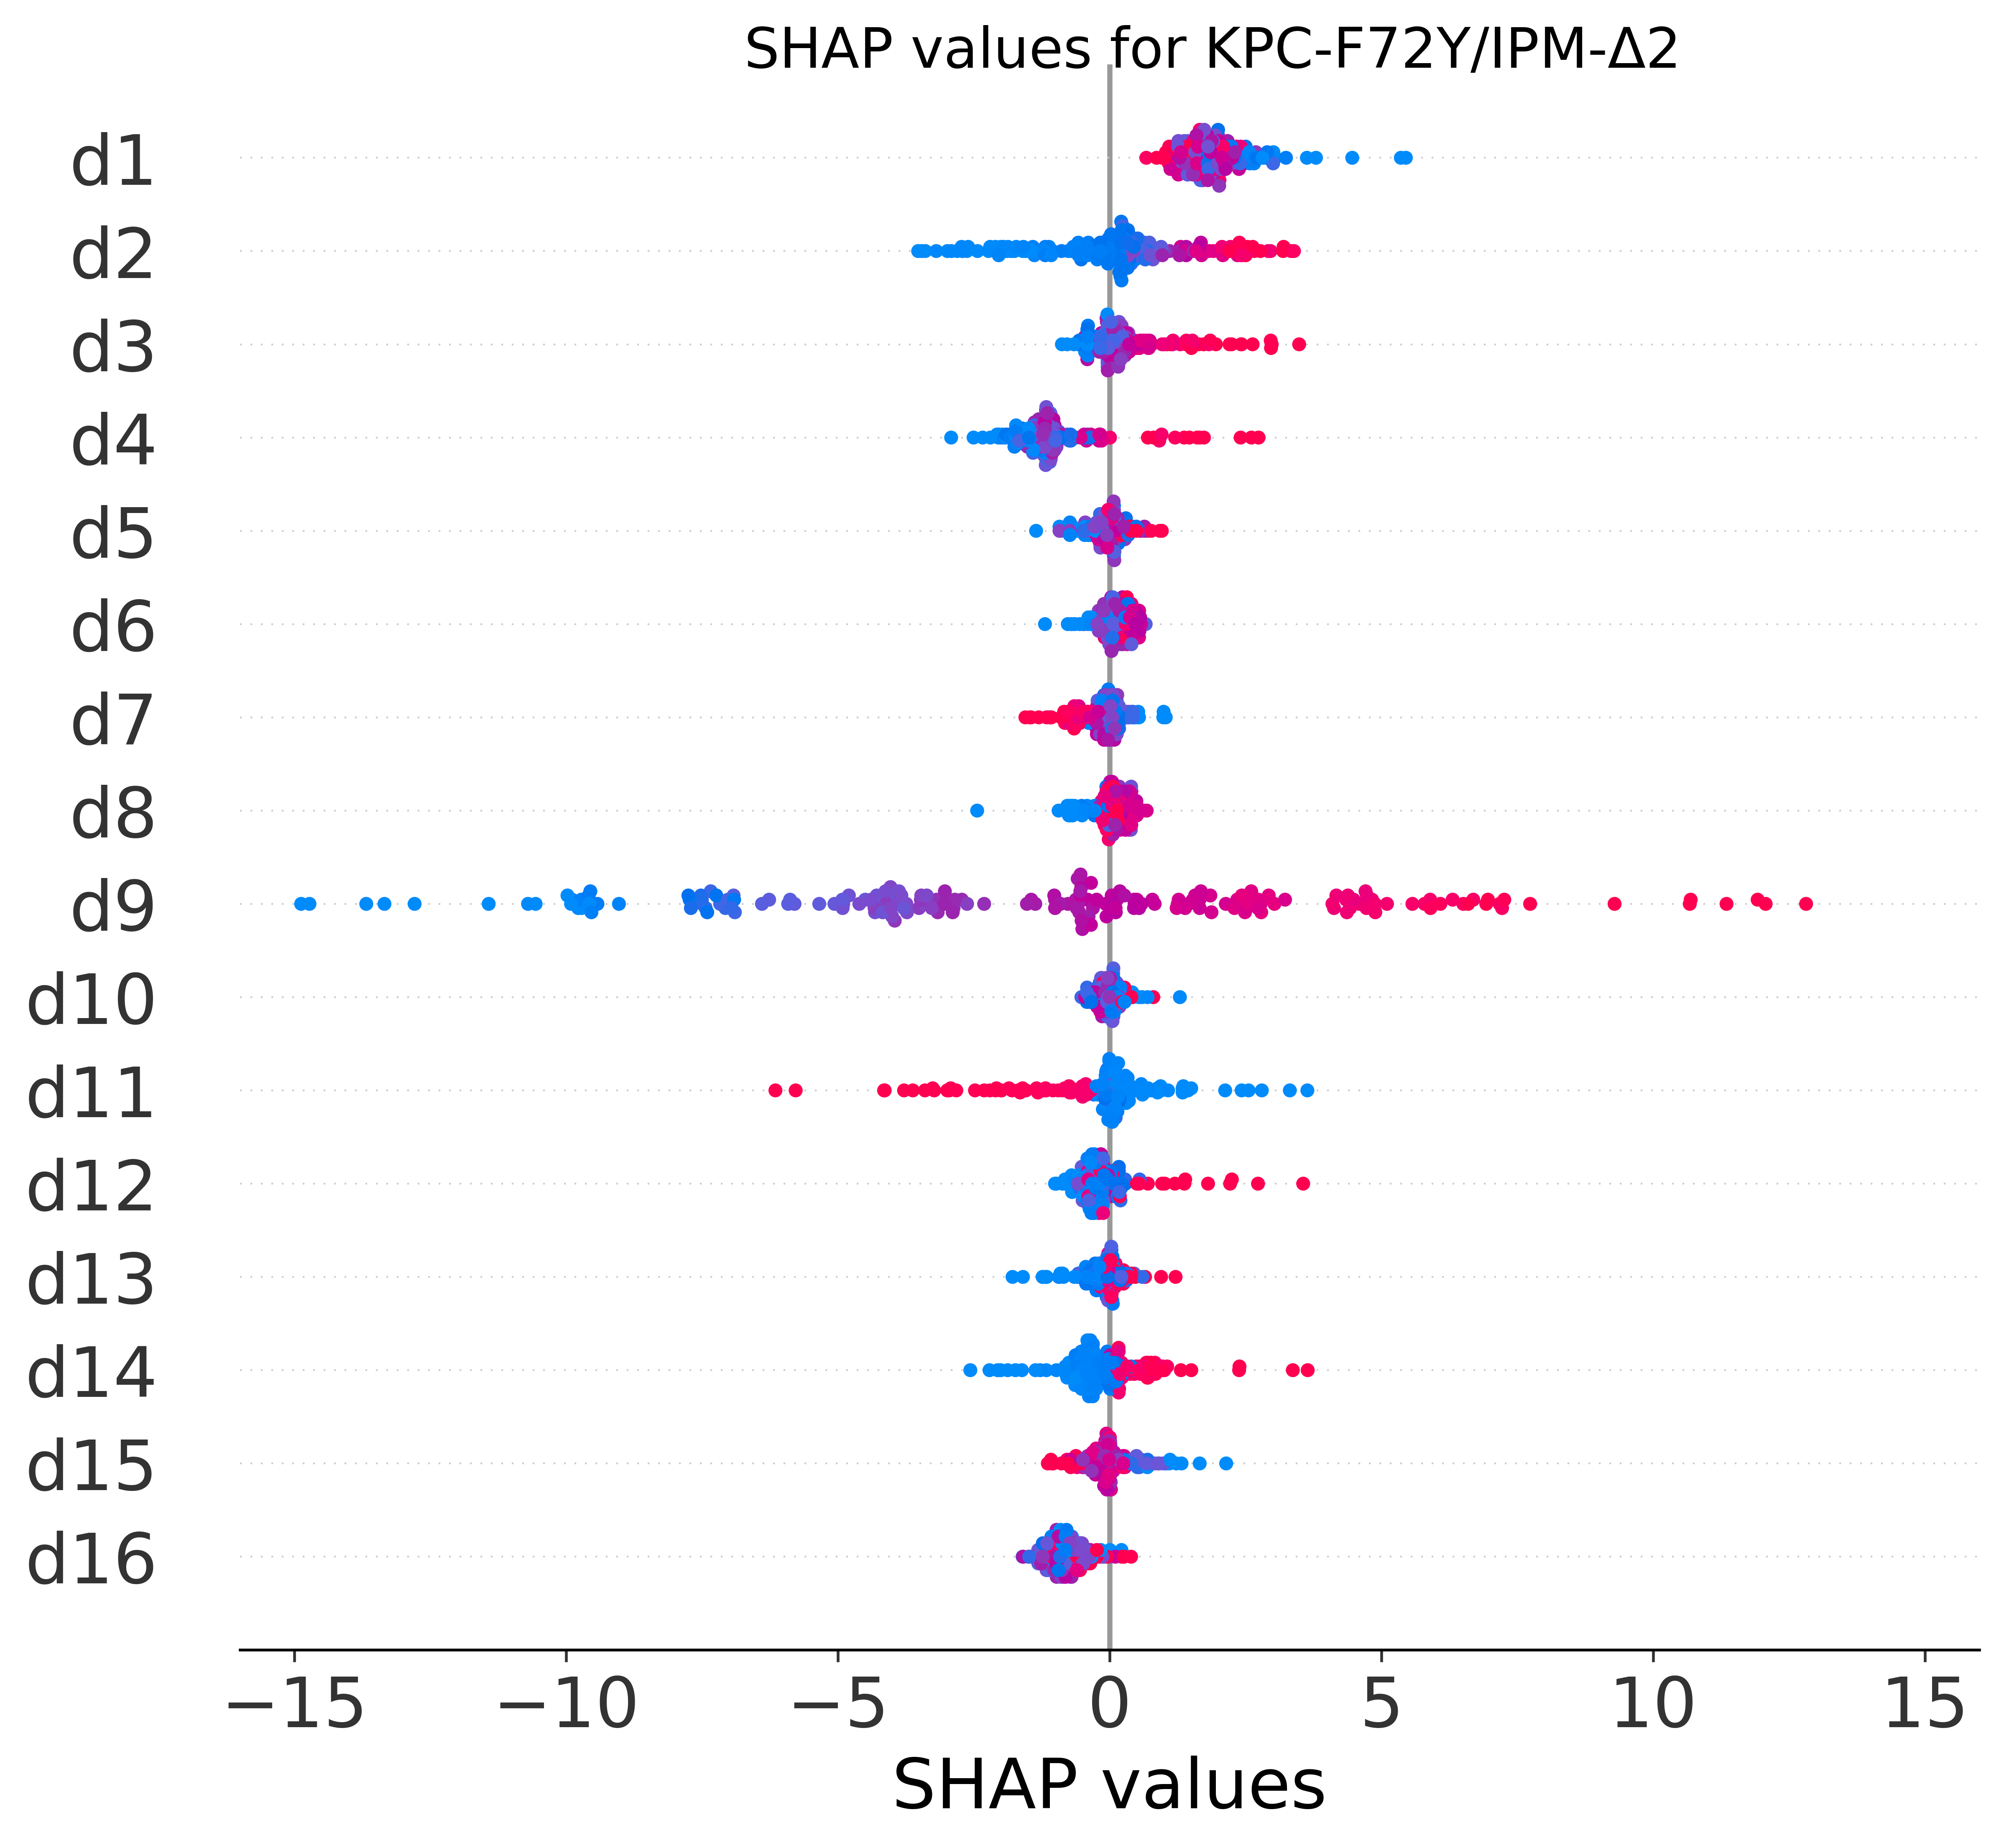

In [35]:
order = [
    "d1",
    "d2",
    "d3",
    "d4",
    "d5",
    "d6",
    "d7",
    "d8",
    "d9",
    "d10",
    "d11",
    "d12",
    "d13",
    "d14",
    "d15",
    "d16",
]

col2num = {col: i for i, col in enumerate(features_df.columns)}

order = list(map(col2num.get, order))

csfont = {'fontname':'Times New Roman'}

fig, ax,  = plt.subplots(figsize=(3.75, 2.5)  ,dpi=600, facecolor='w', edgecolor='k', )
plt.subplots_adjust(left=0.25/3.75, right=3.5/3.75, top=2.25/2.5, bottom=.25/2.5)
shap.plots.beeswarm(shap_value[600:800], order = order, max_display=20, show=False, color_bar = False, )  #order = shap_value.abs.mean(0),
ax.set_yticks(np.arange(0, len(features_name)))

ax.set_xlabel('SHAP values', fontsize = 20)
ax.set_xlim(-16,16)

ax.tick_params(axis='both', which='major', labelsize=20)
fig.suptitle(r'SHAP values for KPC-F72Y/IPM-$\Delta $2', fontsize = 16,x = 0.55,y=0.92)